In [1]:
import pandas as pd
from collections import defaultdict
from sklearn import metrics
from sklearn.metrics import auc
from scipy import interpolate as ip
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np
import os

In [2]:
def find_drop(label, scores, gran = 100):
    gran = 100
    best_fpr, best_tpr, best_thresholds, best_label, best_score, best_auc, best_drop = [],[],[],[],[],0,0
    aucs = []
    for i in range(gran):
        score = [np.nanmean(score[min(int(i / gran * score.shape[0]), score.shape[0] - 1):]) for score in scores]
        fpr, tpr, thresholds = metrics.roc_curve(label, score, pos_label=1)
        if np.isnan(tpr[0]):
            return -1,-1,-1,-1
        AUC = auc(fpr, tpr)
        aucs.append(float(AUC))
        if float(AUC) >= float(best_auc):
            best_fpr, best_tpr, best_thresholds, best_label, best_score, best_auc, best_drop = fpr, tpr, thresholds, label, score, AUC, i
    return best_fpr, best_tpr, best_score, best_auc

In [3]:
def getauc(dir, fprs, fd = False, tf = False, typs = [1,2,3,4,5,6]):
    res = pd.read_csv(dir)
    nums = set(res['car'])
    scores = defaultdict(list)
    labels = defaultdict(list)
    for n in nums:
        typ = n // 1000
        if typ not in typs:
            continue
        if tf:
            typ = 0
        if fd:
            rest = res.sort_values(by='mileage')
            scores[typ] += [rest[rest['car']==n]['rec_error'].values]
        else:
            scores[typ] += [res[res['car']==n]['rec_error'].mean()]
        labels[typ] += [res[res['car']==n]['label'].max()]
    
    aucs = []
    for typ in scores.keys():
        if fd:
            fpr, tpr, _, _ = find_drop(labels[typ], scores[typ])
        else:
            fpr, tpr, thresholds = metrics.roc_curve(labels[typ], scores[typ], pos_label=1)
        
        fprs.update(set(fpr))
        f, t = [fpr[i] for i in range(len(fpr)) if i + 1 == len(fpr) or fpr[i] != fpr[i + 1]], [tpr[i] for i in range(len(fpr)) if i + 1 == len(fpr) or fpr[i] != fpr[i + 1]]

        aucs += [(f, t)]
        
    fauc = lambda x : np.mean([ip.interp1d([fpr[i] for i in range(len(fpr))], tpr, kind='zero', fill_value = 'extrapolate')(x) for fpr, tpr in aucs])
    
    return fauc

In [4]:
def getaucs(dir, tf = False, fd = False, typs = [1,2,3,4,5,6]):
    aucs = []
    fprs = set()
    if dir[-4:] == '.csv':
        aucs = [getauc(dir.format(i), fprs, tf = tf, fd = fd, typs = typs) for i in range(5)]
    else:
        aucs = [getauc(os.path.join(dir, d, f'result/test_segment_{tf if type(tf) == str else "tf" if tf else "normal"}_rec_error.csv'), fprs, tf = tf, fd = fd, typs = typs) for d in os.listdir(dir)]
    
    faucs = lambda x : np.mean([f(x) for f in aucs])
    fmin = lambda x : np.min([f(x) for f in aucs])
    fmax = lambda x : np.max([f(x) for f in aucs])
    
    fpr = []
    tpr = []
    tpr_min = []
    tpr_max = []
    
    for x in sorted(list(fprs)):
        fpr += [x, x]
        tpr += [x if x == 0 else faucs(x - 1e-10), faucs(x)]
        tpr_min += [x if x == 0 else fmin(x - 1e-10), fmin(x)]
        tpr_max += [x if x == 0 else fmax(x - 1e-10), fmax(x)]
        
    print(auc(fpr, tpr))
    
    return fpr, tpr, tpr_min, tpr_max

0.793560606060606


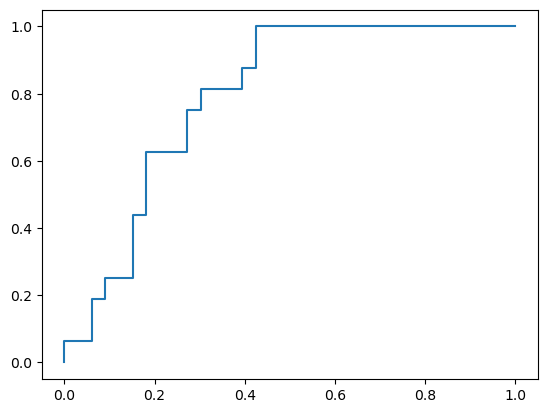

In [7]:
dir = "/cephfs/luobei/unseen_ffn/BA/BA_2_256_[4, 4, 4, 4, 4]"
fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = 'tf_type', fd = True)
plt.plot(fpr, tpr, label = f'Battery Attention(Our Method)')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='blue', alpha=0.1)

0.9331216069678638
0.8276393187237909
0.8845352476846118
0.8253060927665192
0.8484486932116472
0.8077876835361897
0.692433507566647
0.7010382267235395
0.5019874468208648
0.6613421122499599


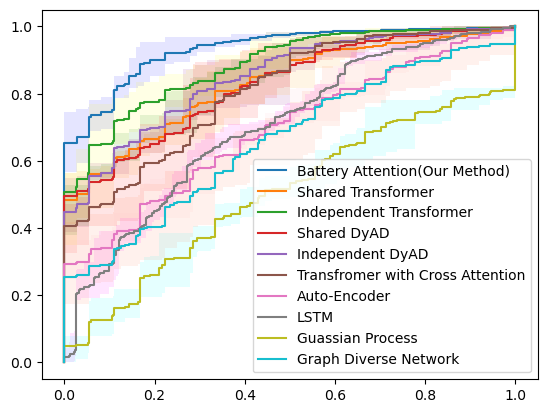

In [6]:
dir = "/cephfs/luobei/BA_ep500/Battery_Attention/BA/BA_2_256_[4, 4, 4, 4, 4]"
fpr, tpr, tpr_min, tpr_max = getaucs(dir, fd = True)
plt.plot(fpr, tpr, label = f'Battery Attention(Our Method)')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='blue', alpha=0.1)

dir = "/cephfs/luobei/BA/BA_2_256_[0, 0]"
fpr, tpr, tpr_min, tpr_max = getaucs(dir)
plt.plot(fpr, tpr, label = f'Shared Transformer')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='purple', alpha=0.1)

dir = "/cephfs/luobei/TF5in5/TF_2_256_[0, 0, 0, 0, 0]"
fpr, tpr, tpr_min, tpr_max = getaucs(dir)
plt.plot(fpr, tpr, label = f'Independent Transformer')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='yellow', alpha=0.1)

dir = '/cephfs/luobei/NC1in5/NC1in5_2_128_[1, 1]'
fpr, tpr, tpr_min, tpr_max = getaucs(dir)
plt.plot(fpr, tpr, label = f'Shared DyAD')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='orange', alpha=0.1)

dir = '/cephfs/luobei/NC5in5/NC5in5_2_128_[1, 1]'
fpr, tpr, tpr_min, tpr_max = getaucs(dir)
plt.plot(fpr, tpr, label = f'Independent DyAD')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='green', alpha=0.1)

dir = '/cephfs/luobei/CA/CA_2_256_[16, 16, 16, 16, 16]'
fpr, tpr, tpr_min, tpr_max = getaucs(dir)
plt.plot(fpr, tpr, label = f'Transfromer with Cross Attention')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='red', alpha=0.1)

dir = '/cephfs/luobei/AE/auto_encoder_normalize_fold{}_rec_error.csv'
fpr, tpr, tpr_min, tpr_max = getaucs(dir)
plt.plot(fpr, tpr, label = f'Auto-Encoder')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='pink', alpha=0.1)

dir = '/cephfs/luobei/LSTM/lstmad_saved_rec_error_fold{}.csv'
fpr, tpr, tpr_min, tpr_max = getaucs(dir)
plt.plot(fpr, tpr, label = f'LSTM')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='magenta', alpha=0.1)

dir = '/cephfs/luobei/GP/y_test_fold{}_scores.csv'
fpr, tpr, tpr_min, tpr_max = getaucs(dir)
plt.plot(fpr, tpr, label = f'Guassian Process')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='aqua', alpha=0.1)

dir = '/cephfs/luobei/GDN/gdn_test_rec_error_fold{}.csv'
fpr, tpr, tpr_min, tpr_max = getaucs(dir)
plt.plot(fpr, tpr, label = f'Graph Diverse Network')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='coral', alpha=0.1)

#plt.xlabel('fpr')
#plt.ylabel('tpr')
#plt.title('AUROC compare with existing method')

plt.legend()
plt.savefig('result_normal.pdf')
plt.show()

0.8323819575092919
0.6522690772266324
0.8429358050750241
0.7153673197815813
0.8214472537053182
0.6911485339329142
0.41264167393199647
0.49198751300728405
0.4671270591474327
0.6181663837011884


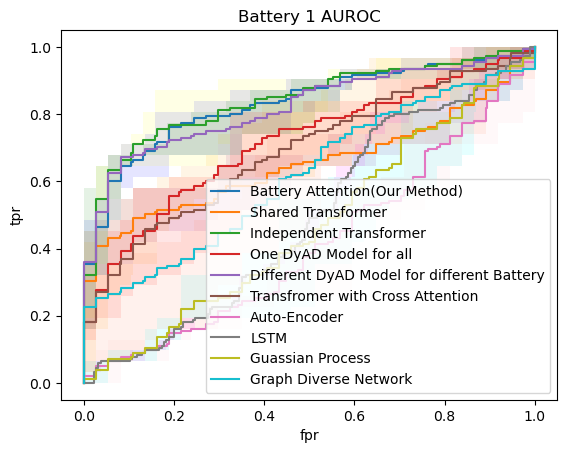

0.9651785714285713
0.8836309523809525
0.9101190476190476
0.8601190476190476
0.8401785714285714
0.7163690476190477
0.5014880952380952
0.5549242424242424
0.4741071428571429
0.5416666666666667


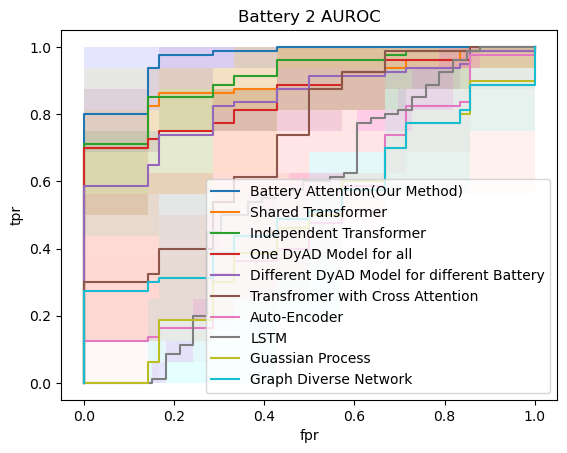

1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9736842105263158
0.0
0.5583333333333333


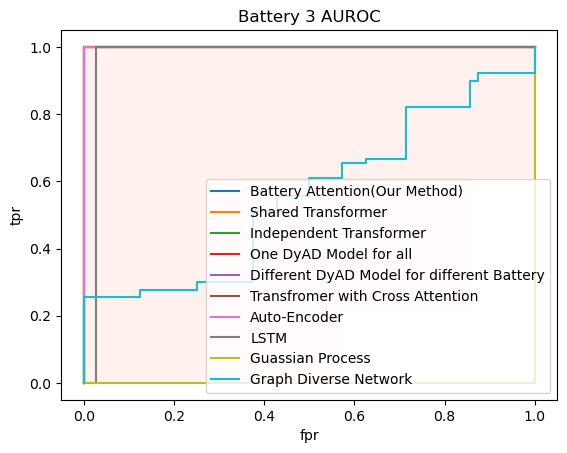

0.9003248862897986
0.7266406757634828
0.8637426900584795
0.694541910331384
0.7892787524366471
0.7058479532163743
0.775438596491228
0.8610500610500611
0.8326185834957766
0.8174788823911632


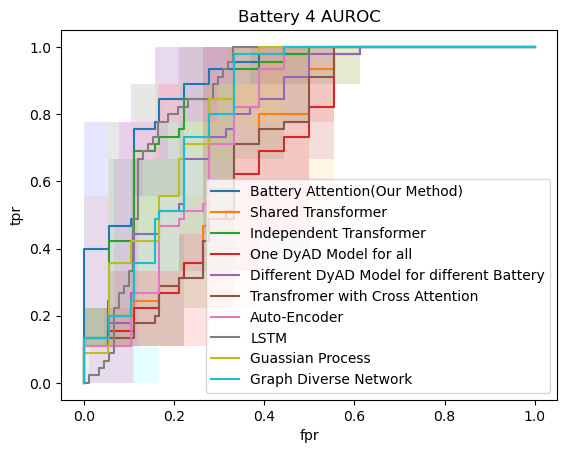

0.9077886710239651
0.7796840958605664
0.7709694989106753
0.7595860566448802
0.7467320261437908
0.8208605664488018
0.7622549019607843
0.7104166666666667
0.7102941176470587
0.7796296296296295


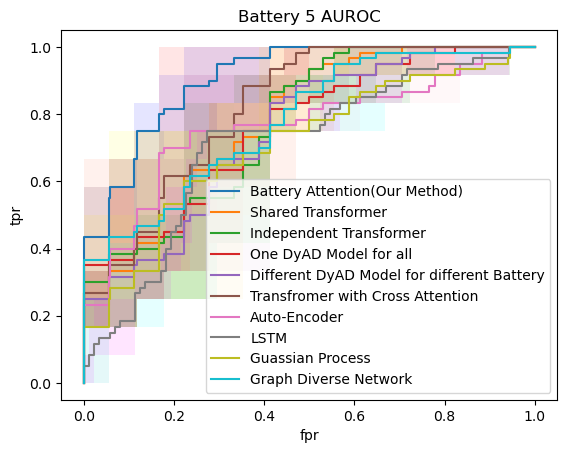

0.9930555555555556
0.9236111111111112
0.9194444444444444
0.9222222222222222
0.8930555555555556
0.9125
0.7027777777777778
0.6141666666666666
0.5277777777777777
0.6527777777777778


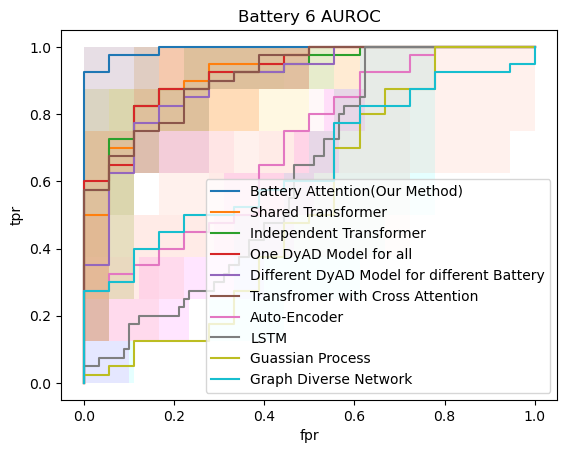

In [7]:
for i in range(1, 7):
    dir = "/cephfs/luobei/BA_ep500/Battery_Attention/BA/BA_2_256_[4, 4, 4, 4, 4]"
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, fd = True, typs = [i])
    plt.plot(fpr, tpr, label = f'Battery Attention(Our Method)')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='blue', alpha=0.1)

    dir = "/cephfs/luobei/BA/BA_2_256_[0, 0]"
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, typs = [i])
    plt.plot(fpr, tpr, label = f'Shared Transformer')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='purple', alpha=0.1)

    dir = "/cephfs/luobei/TF5in5/TF_2_256_[0, 0, 0, 0, 0]"
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, typs = [i])
    plt.plot(fpr, tpr, label = f'Independent Transformer')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='yellow', alpha=0.1)

    dir = '/cephfs/luobei/NC1in5/NC1in5_2_128_[1, 1]'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, typs = [i])
    plt.plot(fpr, tpr, label = f'One DyAD Model for all')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='orange', alpha=0.1)

    dir = '/cephfs/luobei/NC5in5/NC5in5_2_128_[1, 1]'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, typs = [i])
    plt.plot(fpr, tpr, label = f'Different DyAD Model for different Battery')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='green', alpha=0.1)
    
    dir = '/cephfs/luobei/CA/CA_2_256_[16, 16, 16, 16, 16]'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, typs = [i])
    plt.plot(fpr, tpr, label = f'Transfromer with Cross Attention')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='red', alpha=0.1)

    dir = '/cephfs/luobei/AE/auto_encoder_normalize_fold{}_rec_error.csv'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, typs = [i])
    plt.plot(fpr, tpr, label = f'Auto-Encoder')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='pink', alpha=0.1)

    dir = '/cephfs/luobei/LSTM/lstmad_saved_rec_error_fold{}.csv'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, typs = [i])
    plt.plot(fpr, tpr, label = f'LSTM')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='magenta', alpha=0.1)

    dir = '/cephfs/luobei/GP/y_test_fold{}_scores.csv'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, typs = [i])
    plt.plot(fpr, tpr, label = f'Guassian Process')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='aqua', alpha=0.1)

    dir = '/cephfs/luobei/GDN/gdn_test_rec_error_fold{}.csv'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, typs = [i])
    plt.plot(fpr, tpr, label = f'Graph Diverse Network')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='coral', alpha=0.1)


    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title(f'Battery {i} AUROC')

    plt.legend()
    plt.savefig(f'result_{i}.pdf')
    plt.show()

0.8412724643668664
0.7586440311334396
0.7768687230881227
0.6593685199115233
0.6466982756044739
0.6792452066984871
0.5433632417948773
0.7105529312212205


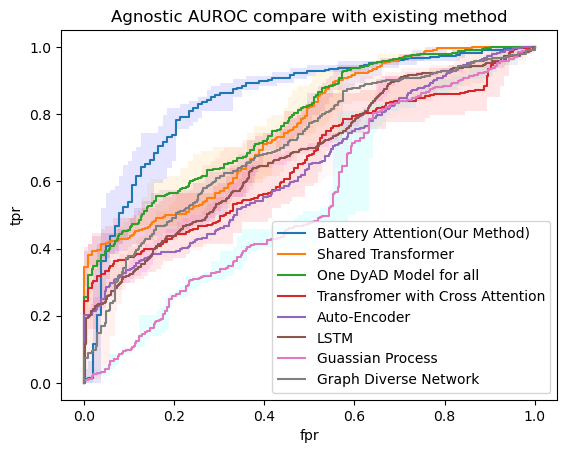

In [8]:
dir = "/cephfs/luobei/BA/BA_2_256_[4, 4]"
fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True, fd = True)
plt.plot(fpr, tpr, label = f'Battery Attention(Our Method)')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='blue', alpha=0.1)

dir = "/cephfs/luobei/BA/BA_2_256_[0, 0]"
fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True)
plt.plot(fpr, tpr, label = f'Shared Transformer')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='purple', alpha=0.1)

dir = '/cephfs/luobei/NC1in5/NC1in5_2_128_[1, 1]'
fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True)
plt.plot(fpr, tpr, label = f'One DyAD Model for all')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='orange', alpha=0.1)

dir = '/cephfs/luobei/CA/CA_2_256_[16, 16, 16, 16, 16]'
fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True)
plt.plot(fpr, tpr, label = f'Transfromer with Cross Attention')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='red', alpha=0.1)

dir = '/cephfs/luobei/AE/auto_encoder_normalize_fold{}_rec_error.csv'
fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True)
plt.plot(fpr, tpr, label = f'Auto-Encoder')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='pink', alpha=0.1)

dir = '/cephfs/luobei/LSTM/lstmad_saved_rec_error_fold{}.csv'
fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True)
plt.plot(fpr, tpr, label = f'LSTM')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='magenta', alpha=0.1)

dir = '/cephfs/luobei/GP/y_test_fold{}_scores.csv'
fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True)
plt.plot(fpr, tpr, label = f'Guassian Process')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='aqua', alpha=0.1)

dir = '/cephfs/luobei/GDN/gdn_test_rec_error_fold{}.csv'
fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True)
plt.plot(fpr, tpr, label = f'Graph Diverse Network')
plt.fill_between(fpr, tpr_min, tpr_max, facecolor='coral', alpha=0.1)

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Agnostic AUROC compare with existing method')

plt.legend()
plt.savefig('result_agnostic.pdf')
plt.show()

0.8268159500757123
0.6522690772266324
0.8429358050750241
0.7155462763272611
0.8216307988803744
0.6443582801817097
0.41264167393199647
0.49198751300728405
0.4671270591474327
0.6181663837011884


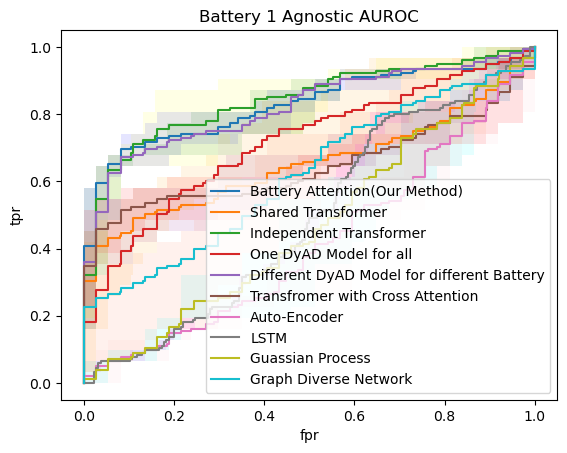

0.962202380952381
0.8836309523809525
0.8851190476190476
0.8583333333333333
0.8366071428571429
0.7940476190476191
0.5014880952380952
0.5549242424242424
0.4741071428571429
0.5416666666666667


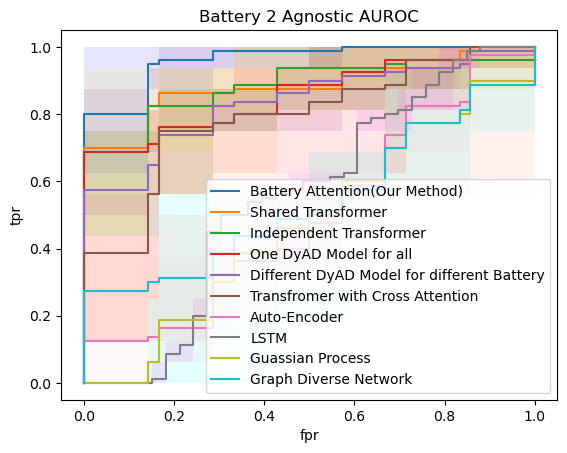

1.0
1.0
1.0
1.0
1.0
0.9748015873015874
1.0
0.9736842105263158
0.0
0.5583333333333333


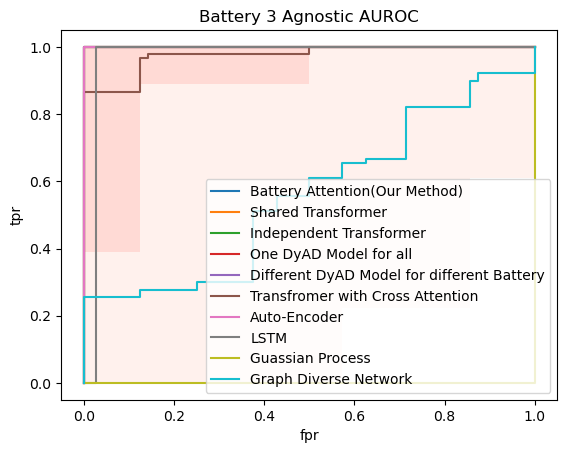

0.888174139051332
0.7266406757634828
0.7701754385964912
0.6933073424301495
0.6732293697205978
0.6948667966211826
0.775438596491228
0.8610500610500611
0.8326185834957766
0.8174788823911632


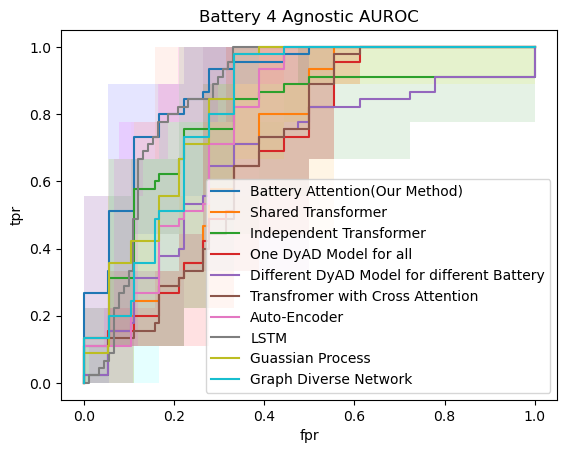

0.8362200435729847
0.7796840958605664
0.7709694989106753
0.7567538126361655
0.7456971677559913
0.7495098039215686
0.7622549019607843
0.7104166666666667
0.7102941176470587
0.7796296296296295


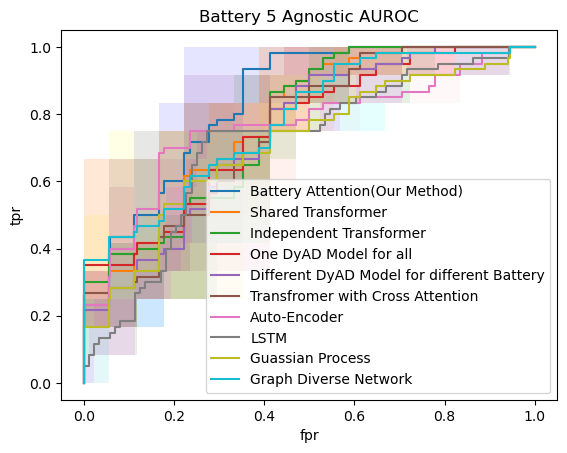

0.9944444444444445
0.9236111111111112
0.8680555555555556
0.923611111111111
0.8902777777777777
0.9125
0.7027777777777778
0.6141666666666666
0.5277777777777777
0.6527777777777778


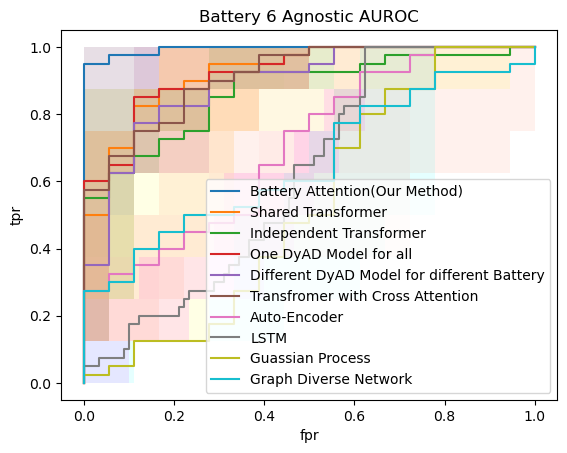

In [9]:
for i in range(1, 7):
    dir = "/cephfs/luobei/BA/BA_2_256_[8, 8]"
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True, fd = True, typs = [i])
    plt.plot(fpr, tpr, label = f'Battery Attention(Our Method)')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='blue', alpha=0.1)

    dir = "/cephfs/luobei/BA/BA_2_256_[0, 0]"
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True, typs = [i])
    plt.plot(fpr, tpr, label = f'Shared Transformer')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='purple', alpha=0.1)

    dir = "/cephfs/luobei/TF5in5/TF_2_256_[0, 0, 0, 0, 0]"
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True, typs = [i])
    plt.plot(fpr, tpr, label = f'Independent Transformer')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='yellow', alpha=0.1)

    dir = '/cephfs/luobei/NC1in5/NC1in5_2_128_[1, 1]'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True, typs = [i])
    plt.plot(fpr, tpr, label = f'One DyAD Model for all')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='orange', alpha=0.1)

    dir = '/cephfs/luobei/NC5in5/NC5in5_2_128_[1, 1]'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True, typs = [i])
    plt.plot(fpr, tpr, label = f'Different DyAD Model for different Battery')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='green', alpha=0.1)
    
    dir = '/cephfs/luobei/CA/CA_2_256_[16, 16, 16, 16, 16]'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True, typs = [i])
    plt.plot(fpr, tpr, label = f'Transfromer with Cross Attention')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='red', alpha=0.1)

    dir = '/cephfs/luobei/AE/auto_encoder_normalize_fold{}_rec_error.csv'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True, typs = [i])
    plt.plot(fpr, tpr, label = f'Auto-Encoder')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='pink', alpha=0.1)

    dir = '/cephfs/luobei/LSTM/lstmad_saved_rec_error_fold{}.csv'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True, typs = [i])
    plt.plot(fpr, tpr, label = f'LSTM')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='magenta', alpha=0.1)

    dir = '/cephfs/luobei/GP/y_test_fold{}_scores.csv'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True, typs = [i])
    plt.plot(fpr, tpr, label = f'Guassian Process')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='aqua', alpha=0.1)

    dir = '/cephfs/luobei/GDN/gdn_test_rec_error_fold{}.csv'
    fpr, tpr, tpr_min, tpr_max = getaucs(dir, tf = True, typs = [i])
    plt.plot(fpr, tpr, label = f'Graph Diverse Network')
    plt.fill_between(fpr, tpr_min, tpr_max, facecolor='coral', alpha=0.1)

    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title(f'Battery {i} Agnostic AUROC')

    plt.legend()
    plt.savefig(f'result_agnostic_{i}.pdf')
    plt.show()